<a href="https://colab.research.google.com/github/Junior11995/Challenge-TelecomX-Parte2-Prediccion/blob/main/Challenge_TelecomX_Parte2_Prediccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# introducción

# 📊 Challenge Telecom X - Parte 2: Predicción de Evasión de Clientes

## 🎯 Introducción
Este desafío forma parte de la segunda etapa del proyecto Telecom X.  
En la Parte 1 trabajamos como analistas de datos explorando, limpiando y generando insights sobre la evasión de clientes (*churn*).  
Ahora, en la Parte 2, nuestro rol es de **científicos de datos** y el objetivo principal es **construir modelos predictivos** que permitan anticipar qué clientes tienen mayor riesgo de cancelar los servicios.

## 📌 Objetivos
- Preparar y separar adecuadamente los datos para modelado (train/test).
- Analizar correlaciones y seleccionar variables relevantes.
- Aplicar conceptos de estadística y regresión lineal.
- Entrenar y evaluar modelos de **Machine Learning de clasificación** para predecir el churn.
- Identificar las variables que más influyen en la evasión.
- Generar un informe con conclusiones y recomendaciones estratégicas para la empresa.

## 🚀 Importancia
Este desafío conecta la teoría con la práctica en un caso real de negocio.  
Al final, entregaremos un **notebook claro y documentado** junto con un **repositorio en GitHub** que refleje cómo la ciencia de datos puede aplicarse para resolver problemas empresariales críticos.


#  Preparación de los Datos

En esta etapa transformamos el dataset tratado en la Parte 1 en un conjunto listo para Machine Learning:

- Eliminamos columnas irrelevantes (`customerid`).
- Convertimos variables categóricas a numéricas (OneHotEncoding).
- Separamos variables explicativas (`X`) de la variable objetivo (`y = churn`).
- Dividimos en datos de entrenamiento y prueba.
- Estandarizamos variables numéricas.


In [4]:
# ============================================
# CARGA ROBUSTA DEL DATASET TRATADO (PARTE 1)
# ============================================
import pandas as pd

LOCAL_PATHS = ["telecom_clean.csv", "/content/telecom_clean.csv"]

df_ml = None
for p in LOCAL_PATHS:
    try:
        df_ml = pd.read_csv(p)
        print(f"✅ Cargado desde: {p}")
        break
    except Exception:
        pass

if df_ml is None:
    try:
        df_ml = pd.read_csv(GITHUB_RAW_URL)
        print(f"✅ Cargado desde URL: {GITHUB_RAW_URL}")
    except Exception as e:
        raise FileNotFoundError(
            "No se pudo cargar 'telecom_clean.csv'. "
            "Asegúrate de tenerlo en el directorio actual o ajusta GITHUB_RAW_URL."
        )

print("Shape:", df_ml.shape)
display(df_ml.head())


✅ Cargado desde: telecom_clean.csv
Shape: (7267, 23)


,id_cliente,evadio,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,...,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges.monthly,account_charges.total,_monthlycharges_std,gasto_diario
0,0002-orfbo,0.0,NaN,0,yes,NaN,9,1.0,0.0,dsl,...,1.0,1.0,0.0,one year,1.0,mailed check,65.6,593.30,NaN,NaN
1,0003-mknfe,0.0,NaN,0,no,NaN,9,1.0,1.0,dsl,...,0.0,0.0,1.0,month-to-month,0.0,mailed check,59.9,542.40,NaN,NaN
2,0004-tlhlj,1.0,NaN,0,no,NaN,4,1.0,0.0,fiber optic,...,0.0,0.0,0.0,month-to-month,1.0,electronic check,73.9,280.85,NaN,NaN
3,0011-igkff,1.0,NaN,1,yes,NaN,13,1.0,0.0,fiber optic,...,0.0,1.0,1.0,month-to-month,1.0,electronic check,98.0,1237.85,NaN,NaN
4,0013-exchz,1.0,NaN,1,yes,NaN,3,1.0,0.0,fiber optic,...,1.0,1.0,0.0,month-to-month,1.0,mailed check,83.9,267.40,NaN,NaN


# PREPARACIÓN DE LOS DATOS PARA ML

In [5]:
# ============================================
# 🛠️ PREPARACIÓN DE LOS DATOS PARA ML
#  - Elimina columnas irrelevantes
#  - Detecta/normaliza la variable objetivo
#  - Split train/test con estratificación
#  - Preprocesador (OneHot + StandardScaler)
# ============================================
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

df_prep = df_ml.copy()

# 1) Drop de columnas irrelevantes (ajusta la lista si tienes más metas/IDs)
drop_cols = [c for c in df_prep.columns if c.lower() in {"customerid", "id_cliente"}]
if drop_cols:
    df_prep = df_prep.drop(columns=drop_cols)

# 2) Detectar columna target (acepta 'churn' o 'evadio')
lower_cols = {c.lower(): c for c in df_prep.columns}
if "churn" in lower_cols:
    target_col = lower_cols["churn"]
elif "evadio" in lower_cols:
    target_col = lower_cols["evadio"]
else:
    raise KeyError("No se encontró la columna objetivo ('churn' o 'evadio').")

# 3) Normalizar target a 0/1
y_raw = df_prep[target_col]
y = (
    y_raw.astype(str).str.strip().str.lower()
      .map({"yes":1,"si":1,"sí":1,"true":1,"1":1, "no":0,"false":0,"0":0})
)
# Si ya viene numérica, convertir respetando valores
if y.isna().mean() > 0.5:
    y = pd.to_numeric(y_raw, errors="coerce")
y = y.astype(float)

# 4) Definir X (el resto de columnas)
X = df_prep.drop(columns=[target_col])

# 5) Columnas categóricas y numéricas
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# 6) Balance de clases (chequeo rápido)
print("Distribución de la clase (target):")
print(y.value_counts(dropna=False))
print("\nDistribución %:")
print((y.value_counts(normalize=True)*100).round(2))

# 7) Split train/test estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("\nShapes → X_train:", X_train.shape, " X_test:", X_test.shape)

# 8) Preprocesador: escala numéricas y OneHot en categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

print("\n✅ Preprocesador listo (StandardScaler + OneHotEncoder).")
print("Numéricas:", len(num_cols), "| Categóricas:", len(cat_cols))

Distribución de la clase (target):
evadio
0.0    5398
1.0    1869
Name: count, dtype: int64

Distribución %:
evadio
0.0    74.28
1.0    25.72
Name: proportion, dtype: float64

Shapes → X_train: (5813, 21)  X_test: (1454, 21)

✅ Preprocesador listo (StandardScaler + OneHotEncoder).
Numéricas: 17 | Categóricas: 4


## 🧹 Eliminación de Columnas Irrelevantes:

En esta etapa, eliminamos columnas que no aportan valor predictivo.  
Por ejemplo, `customerid` es un identificador único de cliente, lo cual no ayuda a predecir la evasión (`churn`).  
Incluir estas variables en el modelo puede incluso perjudicar su desempeño al introducir ruido innecesario.

---


In [7]:
# Cargamos directamente el dataset limpio (ya lo habías subido como telecom_clean.csv)
import pandas as pd

df_ml = pd.read_csv("telecom_clean.csv")

# Eliminamos columnas irrelevantes (ejemplo: identificador único)
cols_to_drop = ["customerid"]

df_ml = df_ml.drop(columns=cols_to_drop, errors="ignore")

print("✅ Columnas eliminadas:", cols_to_drop)
print("📊 Nueva forma del dataset:", df_ml.shape)

# Mostrar primeras filas para confirmar
df_ml.head()

✅ Columnas eliminadas: ['customerid']
📊 Nueva forma del dataset: (7267, 23)


,id_cliente,evadio,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,...,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges.monthly,account_charges.total,_monthlycharges_std,gasto_diario
0,0002-orfbo,0.0,NaN,0,yes,NaN,9,1.0,0.0,dsl,...,1.0,1.0,0.0,one year,1.0,mailed check,65.6,593.30,NaN,NaN
1,0003-mknfe,0.0,NaN,0,no,NaN,9,1.0,1.0,dsl,...,0.0,0.0,1.0,month-to-month,0.0,mailed check,59.9,542.40,NaN,NaN
2,0004-tlhlj,1.0,NaN,0,no,NaN,4,1.0,0.0,fiber optic,...,0.0,0.0,0.0,month-to-month,1.0,electronic check,73.9,280.85,NaN,NaN
3,0011-igkff,1.0,NaN,1,yes,NaN,13,1.0,0.0,fiber optic,...,0.0,1.0,1.0,month-to-month,1.0,electronic check,98.0,1237.85,NaN,NaN
4,0013-exchz,1.0,NaN,1,yes,NaN,3,1.0,0.0,fiber optic,...,1.0,1.0,0.0,month-to-month,1.0,mailed check,83.9,267.40,NaN,NaN


## 🔤 Codificación de Variables Categóricas (Encoding)

Para entrenar modelos de Machine Learning, es necesario transformar las variables categóricas en valores numéricos.  
Utilizamos **One-Hot Encoding** mediante `pandas.get_dummies()`, lo cual genera variables binarias (0/1) para cada categoría.

✅ Se eliminó la primera categoría (`drop_first=True`) para evitar multicolinealidad.  
De esta forma, el dataset queda listo para ser usado en algoritmos de clasificación.


In [8]:
# Verificamos columnas categóricas
cat_cols = df_ml.select_dtypes(include=["object"]).columns.tolist()
print("📋 Columnas categóricas detectadas:", cat_cols)

# Aplicamos One-Hot Encoding con pandas.get_dummies
df_ml_encoded = pd.get_dummies(df_ml, columns=cat_cols, drop_first=True)

print("✅ Codificación completada")
print("📊 Nueva forma del dataset:", df_ml_encoded.shape)

# Mostrar primeras filas para verificar
df_ml_encoded.head()

📋 Columnas categóricas detectadas: ['id_cliente', 'customer_partner', 'internet_internetservice', 'account_contract', 'account_paymentmethod']
✅ Codificación completada
📊 Nueva forma del dataset: (7267, 7292)


,evadio,customer_gender,customer_seniorcitizen,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_onlinesecurity,internet_onlinebackup,internet_deviceprotection,...,id_cliente_9993-lhieb,id_cliente_9995-hotoh,customer_partner_yes,internet_internetservice_fiber optic,internet_internetservice_no,account_contract_one year,account_contract_two year,account_paymentmethod_credit card (automatic),account_paymentmethod_electronic check,account_paymentmethod_mailed check
0,0.0,NaN,0,NaN,9,1.0,0.0,0.0,1.0,0.0,...,False,False,True,False,False,True,False,False,False,True
1,0.0,NaN,0,NaN,9,1.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
2,1.0,NaN,0,NaN,4,1.0,0.0,0.0,0.0,1.0,...,False,False,False,True,False,False,False,False,True,False
3,1.0,NaN,1,NaN,13,1.0,0.0,0.0,1.0,1.0,...,False,False,True,True,False,False,False,False,True,False
4,1.0,NaN,1,NaN,3,1.0,0.0,0.0,0.0,0.0,...,False,False,True,True,False,False,False,False,False,True


## 📊 Verificación de la Proporción de Cancelación (Churn)

Para evaluar si existe un desbalance entre las clases, calculamos la distribución de la variable **churn**.  

- La **proporción absoluta** muestra el número de clientes que cancelaron vs. los que permanecieron activos.  
- La **proporción relativa** permite identificar si hay un **desbalance significativo**, lo cual es importante para entrenar modelos de clasificación.  

En caso de desbalance, se considerará aplicar técnicas como **Oversampling (SMOTE)** o **Undersampling** en pasos posteriores.

📊 Distribución absoluta:
target_bin
0.0    5398
1.0    1869
Name: count, dtype: int64

📊 Distribución relativa (%):
target_bin
0.0    74.28
1.0    25.72
Name: proportion, dtype: float64


/tmp/ipython-input-777629660.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target_bin", data=df_y, palette="Set2")


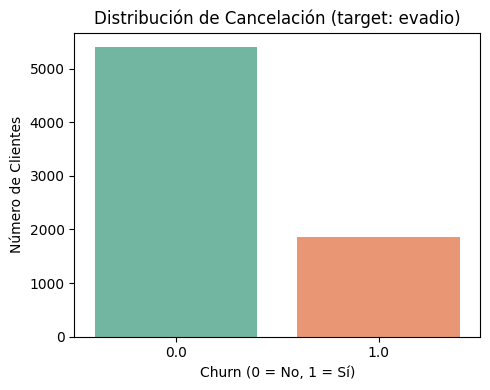

In [10]:
# =========================================================
# 📊 Distribución de Churn
#  - Detecta la columna objetivo entre varios alias (churn/evadio/baja/cancel/evas)
#  - Normaliza a 0/1 si viene como texto (yes/no, si/no, true/false)
#  - Muestra distribución absoluta y relativa + gráfico
# =========================================================
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_chk = df_ml.copy()

# 1) Detectar nombre real de la columna target
aliases = ["churn", "evadio", "baja", "cancel", "cancellation", "evas", "churn_flag", "churned"]
lc_map = {c.lower(): c for c in df_chk.columns}
target_col = None
for a in aliases:
    if a in lc_map:
        target_col = lc_map[a]
        break

if target_col is None:
    # intentemos por regex: contiene 'churn' o 'baja' o 'cancel' o 'evas'
    patt = re.compile(r"(churn|baja|cancel|evas)", re.I)
    for c in df_chk.columns:
        if patt.search(c):
            target_col = c
            break

if target_col is None:
    raise KeyError("No se encontró la columna objetivo (ej.: 'churn' / 'evadio' / 'baja'). Revisa df_ml.columns")

# 2) Normalizar target a 0/1
y_raw = df_chk[target_col]
y = (
    y_raw.astype(str).str.strip().str.lower()
       .map({"yes":1,"si":1,"sí":1,"true":1,"1":1, "no":0,"false":0,"0":0})
)
if y.isna().mean() > 0.5:  # si la mayoría quedó NaN, intentemos convertir a numérico directamente
    y = pd.to_numeric(y_raw, errors="coerce")
# Si aún hay NaN pocos, los quitamos para el conteo
y = y.dropna()
df_y = y.to_frame(name="target_bin")

# 3) Distribuciones
print("📊 Distribución absoluta:")
print(df_y["target_bin"].value_counts().astype(int))

print("\n📊 Distribución relativa (%):")
print((df_y["target_bin"].value_counts(normalize=True)*100).round(2))

# 4) Visualización
plt.figure(figsize=(5,4))
sns.countplot(x="target_bin", data=df_y, palette="Set2")
plt.title(f"Distribución de Cancelación (target: {target_col})")
plt.xlabel("Churn (0 = No, 1 = Sí)")
plt.ylabel("Número de Clientes")
plt.tight_layout()
plt.show()